# Import Packages

In [114]:
!pip install statsmodels
!pip install distinctipy

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
import scipy
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from PIL import Image
from sklearn import metrics
from functools import reduce
import operator
import warnings
from datetime import date
warnings.filterwarnings("ignore", message="Covariance of the parameters could not be estimated")
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import math
import matplotlib
from scipy import stats
import distinctipy
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import tqdm as tqdm
from statsmodels.tsa.stattools import grangercausalitytests
import tqdm

# Import Data

In [116]:
df_master=pd.read_parquet('/Users/jackpettigrewwhelan/Desktop/temp_project-dawes-jones_data_gulf_coast_rul_branded_plus_opis_codes_2016_2023_rack_spot.parquet')

In [117]:
display(df_master)

,date,market,state,city,supplier,brand_indicator,product_name,octane_level,product_grade,spot_product_name,discounted_gross_price,spot_price
0,2023-03-13,Gulf Coast,TX,Abilene,Cenex,b,CBOB Ethanol 10%,87,UNL,CBOB Unl,253.509,237.14
1,2023-03-13,Gulf Coast,GA,Albany,Citgo,b,CBOB Ethanol 10%,87,UNL,CBOB Unl,235.551,237.14
2,2023-03-13,Gulf Coast,GA,Atlanta,BP,b,CBOB Ethanol 10%,87,UNL,CBOB Unl,237.148,237.14
3,2023-03-13,Gulf Coast,GA,Bainbridge,Marathon,b,CBOB Ethanol 10%,87,UNL,CBOB Unl,241.699,237.14
4,2023-03-13,Gulf Coast,MD,Baltimore,76-Mot,b,RFG Ethanol 10%,87,UNL,RBOB Unleaded Regular,240.249,238.89
...,...,...,...,...,...,...,...,...,...,...,...,...
2631711,2022-11-29,Gulf Coast,TN,Chattanooga,Texaco,b,CBOB Ethanol 10%,87,UNL,CBOB Unl,220.311,207.78
2631712,2022-11-29,Gulf Coast,TX,Corpus Christi,76-Mot,b,CBOB Ethanol 10%,87,UNL,CBOB Unl,213.932,207.78
2631713,2022-11-29,Gulf Coast,TX,Dallas Proper,Sunoco,b,RFG Ethanol 10%,87,UNL,RBOB Unleaded Regular,210.259,211.78
2631714,2022-11-29,Gulf Coast,TX,Dallas/Ft. Worth,Shell-Mot,b,RFG Ethanol 10%,87,UNL,RBOB Unleaded Regular,208.629,211.78


In [119]:
# Get top 10 cities with most datapoints
cities = df_master.city.unique()
city_sizes = {}
for city in cities:
    city_sizes[city] = len(df_master[df_master.city==city].index)
    
top_10 = []
for i in range(15):
    city = max(city_sizes, key=city_sizes.get)
    top_10.append(city)
    del city_sizes[city]
print(top_10)

['Richmond', 'Columbus', 'Norfolk', 'Caddo Mills', 'Fairfax', 'Atlanta', 'Memphis', 'Bainbridge', 'Chattanooga', 'Knoxville', 'Macon', 'Birmingham', 'Montgomery', 'Collins', 'Spartanburg']


In [107]:
# Get list of all unique cities in dataset
cities = df_master.city.unique()
print(cities)

['Abilene' 'Albany' 'Atlanta' 'Bainbridge' 'Baltimore' 'Athens' 'Austin'
 'Baton Rouge' 'Big Spring' 'Brownsville' 'Birmingham' 'Charleston'
 'Chattanooga' 'Columbus' 'Evansville' 'Anniston/Oxford' 'Arcadia'
 'Beaumont' 'Caddo Mills' 'Cape Girardeau' 'Center' 'Charlotte'
 'Dallas/Aledo' 'Dallas/Ft. Worth' 'Collins' 'Dallas/Grapevine' 'El Paso'
 'Harlingen' 'Knoxville' 'Macon' 'Corpus Christi' 'Dallas Metro' 'Fairfax'
 'Greenville' 'Evansville Proper' 'Hearne' 'Jacksonville' 'Laredo'
 'Little Rock' 'Edinburg' 'Houston' 'Lake Charles' 'Lexington' 'Memphis'
 'Meridian' 'Miami' 'Midland/Odessa' 'Mobile' 'Monroe' 'Montgomery'
 'Nashville' 'New Orleans' 'Niceville' 'Norfolk' 'North Augusta'
 'Opelousas' 'Orlando' 'Panama City' 'Pt. Everglades' 'Richmond' 'Roanoke'
 'Rogers' 'Savannah' 'Selma' 'Sheerin' 'Shreveport' 'Spartanburg' 'Taft'
 'Tampa' 'Three Rivers' 'Tucson' 'Vicksburg' 'Waco' 'Waskom'
 'Wichita Falls' 'Boligee' 'Convent/Garyville' 'Owensboro' 'San Antonio'
 'Aberdeen' 'El Dorado' 

In [108]:
# Check for duplicates
assert pd.Index(df[groupby_cols + ["date"]]).is_unique, "have duplicates"

In [109]:
# Get dictionary representation of matrix data
ts_dict = {":".join([str(name) for name in names]): group.set_index("date") for names, group in df.groupby(groupby_cols, observed=True)}

In [110]:
# Get rid of data for supplier with too few datapoints
del ts_dict['MPC-ARCO:Atlanta:CBOB Ethanol 10%:87']

KeyError: 'MPC-ARCO:Atlanta:CBOB Ethanol 10%:87'

### Set Date Range

In [ ]:
# Set time interval over which data will be analyzed for patterns
months = pd.period_range('2016-01-01', '2016-12-31', freq="Q")

## Functions

In [ ]:
def cleanup(t1,t2):
    """
    Modify a pair of pandas series so that they both only contain common indices
    inputs:
    t1 - a pandas series; t2 - a pandas series
    outputs:
    t1 - a pandas series; t2 - a pandas series
    """
    t1=t1[t1.index.isin(t2.index)]
    t2=t2[t2.index.isin(t1.index)]
    return t1,t2

In [ ]:
def mae(t1, t2):
    """
    Calculate the mean absolute error between t1 and t2
    inputs:
    t1 - a pandas series; t2 - a pandas series
    outputs:
    A float representing MAE
    """
    t1, t2 = cleanup(t1, t2)
    return metrics.mean_absolute_error(t1, t2)

In [ ]:
def rmse(t1, t2):
    """
    Calculate root mean squared error between t1 and t2
    inputs:
    t1 - a pandas series; t2 - a pandas series
    outputs:
    A float representing RMSE
    """
    t1, t2 = cleanup(t1, t2)
    return metrics.mean_squared_error(t1, t2)

In [ ]:
def pearson(t1, t2):
    """
    Calculate pearson correlation coefficient between t1 and t2
    inputs:
    t1 - a pandas series; t2 - a pandas series
    outputs:
    A float representing pearson correlation coefficient
    """
    t1, t2 = cleanup(t1, t2)
    return 1 - t1.corr(t2, method='pearson')

In [ ]:
def kendall(t1, t2):
    """
    Calculate kendall rank correlation coefficient between t1 and t2
    inputs:
    t1 - a pandas series; t2 - a pandas series
    outputs:
    A float representing kendall rank correlation coefficient
    """
    t1, t2 = cleanup(t1, t2)
    return 1 - t1.corr(t2, method='kendall')

In [ ]:
def spearman(t1, t2):
    """
    Calculate spearman rank correlation coefficient between t1 and t2
    inputs:
    t1 - a pandas series; t2 - a pandas series
    outputs:
    A float representing spearman rank correlation coefficient
    """
    t1, t2 = cleanup(t1, t2)
    return 1 / t1.corr(t2, method='spearman')

In [ ]:
def granger(t1, t2):
    """
    WIP
    Calculate granger correlation between t1 and t2
    inputs:
    t1 - a pandas series; t2 - a pandas series
    outputs:
    A float representing granger correlation
    """
    t1, t2 = cleanup(t1, t2)
    df_merged=pd.concat([t1,t2],axis=1)
    err = grangercausalitytests(df_merged, [1, 2, 3], verbose=False)
    return 1 - (err[1][0]['ssr_ftest'][0])

In [ ]:
def metric_w_shift(t1, t2, metric):
    """
    returns specified error metric between t1 and t2 w/ best-fit vertical shift and what that shift is
    Inputs:
    t1 - a pandas series; t2 - a pandas series; metric - the name of a function which returns a float representing error 
    Outputs:
    metric(t1, t2_a) - error between t1 and t2 with vertical shift applied to most closely match them
    a - a float representing the vertical shift which minimizes error between t1 and t2
    """

    t1, t2 = cleanup(t1, t2)
    param, param_cov = curve_fit(shift, t2, t1)
    a = param[0]
    t2_a = t2 + a
    return metric(t1, t2_a), a

In [ ]:
def metric_w_coupling(t1, t2, t3, f, metric):
    """
    returns specified error metric of fit with coupled function and best-fit shift
    """

    t23 = f(t2, t3)
    return metric_w_shift(t1, t23, metric)

In [ ]:
def shift(x, a):
    """
    Apply a shift a to dataframe x
    """
    return x + a

In [ ]:
def minimum(t2, t3):
    """
    Return a numpy array representing the minimum of t2 and t3 at each shared index.
    inputs:
    t2 - a pandas series; t3 - a pandas series
    """
    t2, t3 = cleanup(t2, t3)
    return np.minimum(t2, t3)

In [ ]:
def maximum(t2, t3):
    """
    Return a numpy array representing the maximum of t2 and t3 at each shared index.
    inputs:
    t2 - a pandas series; t3 - a pandas series
    """
    t2, t3 = cleanup(t2, t3)
    return np.maximum(t2, t3)

In [ ]:
def average(t2, t3):
    """
    Return a numpy array representing the average of t2 and t3 at each shared index.
    inputs:
    t2 - a pandas series; t3 - a pandas series
    """
    t2, t3 = cleanup(t2, t3)
    return (t2 + t3) / 2

In [ ]:
def simple_strategies(ts_dict, metric = mae):
    """
    find best-fit strategies based on specified metric; includes only single-company-with-gain strategies 
    """

    # find best-fit strategies
    ts = list(ts_dict.keys())
    strategies = pd.DataFrame(columns=["best_fit", "error"], index=ts)
    for t1 in ts:
        p1 = ts_dict.get(t1).discounted_gross_price
        errors = []
        for t2 in ts:
            if t1 == t2:
                errors.append(math.inf)
            else:
                p2 = ts_dict.get(t2).discounted_gross_price
                error = metric(p1, p2)
                errors.append(error)
        strategies.at[t1, "best_fit"] = ts[np.argmin(errors)]
        strategies.at[t1, "error"] = min(errors)

    return strategies

In [ ]:
def coupled_strategies(ts_dict, metric = mae):
    """
    finds best-fit strategies based on specified metric;
    includes only coupled-company-with-gain strategies
    """

    # list of coupled strategies
    possible = [minimum, maximum, average]
    
    # find best-fit strategies
    ts = list(ts_dict.keys())
    n = len(ts)
    strategies = pd.DataFrame(
        columns=["best_fit_type", "best_fit", "a", "error"], index=ts
    )
    for t1 in ts:
        p1 = ts_dict.get(t1).discounted_gross_price
        errors = np.full((n, n, 3), math.inf)
        shifts = np.full((n, n, 3), 0, dtype=float)
        for i in range(n):
            for j in range(i + 1, n):
                t2 = ts[i]
                t3 = ts[j]
                if (t1 != t2) and (t1 != t3):
                    p2 = ts_dict.get(t2).discounted_gross_price
                    p3 = ts_dict.get(t3).discounted_gross_price
                    for k in range(len(possible)):
                        f = possible[k]
                        errors[i, j, k], shifts[i, j, k] = metric_w_coupling(
                            p1, p2, p3, f, metric)
        ind = np.unravel_index(np.argmin(errors), errors.shape)
        strategies.at[t1, "best_fit_type"] = possible[ind[2]].__name__
        strategies.at[t1, "best_fit"] = (ts[ind[0]], ts[ind[1]]) 
        strategies.at[t1, "a"] = shifts[ind]
        strategies.at[t1, "error"] = errors[ind]

    return strategies

In [ ]:
def get_period(ts_dict, month):
    """
    Return a dictionary that only contains subsets of dataframes which fall within a time period
    Inputs:
    ts_dict, a dictionary where keys are timeseries IDs and values are pandas dataframes
    month, a datetime object specifying a unit of time (month, quarter, year .etc)
    Outputs:
    ts_pd_dict, a dictionary where keys are timeseries IDs and values are pandas dataframes
    """
    ts_pd_dict = {}
    for key in ts_dict.keys():
        data = ts_dict[key]
        months = data.index.to_numpy().astype('datetime64[M]')
        mask = months == month.to_timestamp().to_numpy().astype("datetime64[M]")
        data = data[mask]
        if not data.empty:
            ts_pd_dict[key] = data
    return ts_pd_dict

In [ ]:
def run_strategy(a_dict, strategy):
    """
    Determine best-fit strategy for each unit of time specified by date
    inputs:
    a_dict, dictionary where keys are timeseries IDs and values are pandas dataframes
    strategy, a function which determines the best-fit strategy for a dictionary of dataframes
    outputs:
    simple_strategy_dict, a nested dictionary where keys are units of time, nested keys are timeseries 
    IDs, and nested values are best-fit strategies.
    """
    simple_strategy_dict = {}
    simple_corr_dict = {}
    for month in tqdm.tqdm(months):
        data = get_period(a_dict, month)
        strats_pd = strategy(data)
        simple_strategy_dict[str(month)] = strats_pd['best_fit'].to_dict()
        simple_corr_dict[str(month)] = strats_pd['error'].to_dict()
    print('done')
    return(simple_strategy_dict, simple_corr_dict)

In [ ]:
def generate_strat(series_id):
    """
    Generate baseline strategy where prices are changed by a ratio of change in spot price
    inputs:
    series_id, a key(timeseries ID) for a value (pandas dataframe) in dictionary ts_dict
    outputs:
    pred_price, a pandas dataframe representing predicted rack price for a supplier based on
    baseline strategy
    """
    data = ts_dict[series_id]
    df_baseline_strats = est_baseline_strategy(ts_dict)
    c = df_baseline_strats.at[series_id, 'c']
    pred_price = pd.DataFrame(columns=['discounted_gross_price'], index=data.index)
    for date in data.index:
        shift = datetime.timedelta(days=1)
        if (date-shift in data.index) and (date+shift in data.index):
            s_td = data.at[date, 'spot_price']
            s_yd = data.at[date-shift, 'spot_price']
            r_td = data.at[date, 'discounted_gross_price']
            pred_price.loc[date+shift] = c*(s_td-s_yd) + r_td
    return pred_price

In [ ]:
def get_map(df_to_map, title):
    """
    Create a spy plot of a pandas dataframe of strings
    """
    plt.figure()
    indices = list(df_to_map.index)
    my_colors = distinctipy.get_colors(len(indices))
    my_colormap = ListedColormap(my_colors)
    
    plt.rcParams["figure.dpi"] = 300
    plt.figure(figsize=(20,8))
    
    for item in indices:
        df_to_map = df_to_map.replace(to_replace=item, value=indices.index(item))

    plt.imshow(df_to_map, cmap = my_colormap)
    plt.xticks(range(len(df_to_map.columns)), df_to_map.columns, rotation=90, fontsize=10)
    plt.grid(False)
    
    indices = [w.split(':', 1)[0] for w in indices]
    
    plt.yticks(range(len(indices)), indices, rotation=0, fontsize=10)
    
    patches = [ mpatches.Patch(color=my_colors[i], label="{l}".format(l=indices[i]) ) for i in range(len(indices)) ]

    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    
    plt.title(title)
    
    

In [ ]:
def est_baseline_strategy(ebs_dict):
    """
    Create a dataframe which approximates the percent of spot price a supplier takes for each supplier in ebs_dict
    inputs:
    ebs_dict, a dictionary where keys are timeseries IDs 
    """
    norm_dict = {}
    strategy_coeffs = {}
    pred_chg = {}
    corr_coeffs = {}
    ts=list(ebs_dict.keys())
    error_dict={}
    strategies=pd.DataFrame(columns=['c','correlation coefficient'])
    #,index=ts
    for key in ebs_dict.keys():
        ds_spot = ebs_dict[key]["spot_price"]
        ds_price = ebs_dict[key]["discounted_gross_price"]
        norm_dict[key] = ds_price.diff() / ds_spot.diff().shift(1)
    df_norm = pd.DataFrame(norm_dict)
    df_norm = df_norm[abs(df_norm) < 5]
    
    
    for key in ts_dict.keys():
        ds_spot_chg = ts_dict[key]["spot_price"].diff().shift(1)
        pred_chg[key] = ds_spot_chg*np.nanmean(df_norm[key])
        ds_price_diff = ts_dict[key]["discounted_gross_price"].diff()
        #error_dict[key] = ds_price_diff.corr(pred_chg[key])
        strategies.at[key,'correlation coefficient']=ds_price_diff.corr(pred_chg[key])
        strategies.at[key,'c']=np.nanmean(df_norm[key])

    return strategies

In [ ]:
def get_best_strats(gbs_dict):
    """
    finds best-fit strategies based on specified metric;
    includes only single-company-with-gain strategies
    """ 
    # find best-fit strategies
    ts=list(gbs_dict.keys())
    strategies=pd.DataFrame(columns=['best_fit', 'correlation coefficient'],index=ts)
    for t1 in ts:
        correlations = {}
        df1 = gbs_dict[t1]
        p1=gbs_dict.get(t1).discounted_gross_price
        for t2 in ts:
            if t1!=t2:
                p2=gbs_dict.get(t2).discounted_gross_price
                p1, p2 = cleanup(p1, p2)
                correlations[t2] = p1.corr(p2)
        best_fit = max(correlations, key = correlations.get)
        strategies.at[t1,'best_fit']=  max(correlations, key = correlations.get)
        strategies.at[t1,'correlation coefficient']= correlations[best_fit]
        
    return strategies

In [ ]:
def get_best_strats_diff(gbs_dict):
    ts=list(gbs_dict.keys())
    strategies=pd.DataFrame(columns=['best_fit', 'correlation coefficient'],index=ts)
    for t1 in ts:
        correlations = {}
        p1=gbs_dict.get(t1).discounted_gross_price.diff()
        for t2 in ts:
            if t1 != t2:
                p2=gbs_dict.get(t2).discounted_gross_price.diff()
                correlations[t2] = p1.corr(p2)
                best_fit = max(correlations, key=correlations.get)
                strategies.at[t1,'best_fit']=  best_fit
                strategies.at[t1,'correlation coefficient']= correlations[best_fit]
    return strategies

In [ ]:
def plot_freq(df_to_plot):
    indices = list(df_to_plot.index)
    print(indices)
    plt.rcParams["figure.dpi"] = 300
    matplotlib.style.use('fivethirtyeight') 
    for index in indices:
        if ('Average' not in index) and ('High' not in index) and ('Low' not in index):
            suppliers_list = list(df_to_plot.loc[index])
            suppliers_list = [item for item in suppliers_list if isinstance(item, str)]
            suppliers_list = [w.split(':', 1)[0] for w in suppliers_list]
            supplier_counts = Counter(suppliers_list)
            df_plot = pd.DataFrame.from_dict(supplier_counts, orient='index')
            df_plot.plot(kind='bar', legend=False)
            title = index.split(':', 1)[0]
            title += ' (Atlanta Market)'
            plt.title(title)

# Run Functions

In [ ]:
ts_dict = {":".join([str(name) for name in names]): group.set_index("date") for names, group in df.groupby(groupby_cols, observed=True)}

In [ ]:
# Set time interval over which data will be analyzed for patterns
months = pd.period_range('2016-01-01', '2022-12-31', freq="Q")

In [ ]:
best_strats, best_strats_error = run_strategy(ts_dict, simple_strategies)
df_best_strats = pd.DataFrame.from_dict(data=best_strats, orient='columns')
df_best_strats_error = pd.DataFrame.from_dict(data=best_strats_error, orient='columns')

In [ ]:
df_best_strats = pd.DataFrame.from_dict(data=best_strats, orient='columns')
df_best_strats_error = pd.DataFrame.from_dict(data=best_strats_error, orient='columns')

In [46]:
display(df_best_strats)

,2016Q1,2016Q2,2016Q3,2016Q4,2017Q1,2017Q2,2017Q3,2017Q4,2018Q1,2018Q2,...,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3,2021Q4,2022Q1,2022Q2,2022Q3,2022Q4
BP:Atlanta:CBOB Ethanol 10%:87,Branded Average:Atlanta:CBOB Ethanol 10%:0,Chevron:Atlanta:CBOB Ethanol 10%:87,Branded Average:Atlanta:CBOB Ethanol 10%:0,Branded Average:Atlanta:CBOB Ethanol 10%:0,Chevron:Atlanta:CBOB Ethanol 10%:87,Chevron:Atlanta:CBOB Ethanol 10%:87,Chevron:Atlanta:CBOB Ethanol 10%:87,Shell-Mot:Atlanta:CBOB Ethanol 10%:87,Chevron:Atlanta:CBOB Ethanol 10%:87,XOM:Atlanta:CBOB Ethanol 10%:87,...,Branded Average:Atlanta:CBOB Ethanol 10%:0,Sunoco:Atlanta:CBOB Ethanol 10%:87,Branded Average:Atlanta:CBOB Ethanol 10%:0,Branded Average:Atlanta:CBOB Ethanol 10%:0,Branded Average:Atlanta:CBOB Ethanol 10%:0,Branded Average:Atlanta:CBOB Ethanol 10%:0,Gulf:Atlanta:CBOB Ethanol 10%:87,Branded Average:Atlanta:CBOB Ethanol 10%:0,Branded Average:Atlanta:CBOB Ethanol 10%:0,Chevron:Atlanta:CBOB Ethanol 10%:87
Branded Average:Atlanta:CBOB Ethanol 10%:0,Marathon:Atlanta:CBOB Ethanol 10%:87,Chevron:Atlanta:CBOB Ethanol 10%:87,BP:Atlanta:CBOB Ethanol 10%:87,BP:Atlanta:CBOB Ethanol 10%:87,BP:Atlanta:CBOB Ethanol 10%:87,BP:Atlanta:CBOB Ethanol 10%:87,Shell-Mot:Atlanta:CBOB Ethanol 10%:87,76-Mot:Atlanta:CBOB Ethanol 10%:87,Valero:Atlanta:CBOB Ethanol 10%:87,Sunoco:Atlanta:CBOB Ethanol 10%:87,...,Valero:Atlanta:CBOB Ethanol 10%:87,Valero:Atlanta:CBOB Ethanol 10%:87,Valero:Atlanta:CBOB Ethanol 10%:87,Sunoco:Atlanta:CBOB Ethanol 10%:87,BP:Atlanta:CBOB Ethanol 10%:87,BP:Atlanta:CBOB Ethanol 10%:87,Sunoco:Atlanta:CBOB Ethanol 10%:87,Valero:Atlanta:CBOB Ethanol 10%:87,XOM:Atlanta:CBOB Ethanol 10%:87,Shell-Mot:Atlanta:CBOB Ethanol 10%:87
Branded High:Atlanta:CBOB Ethanol 10%:0,XOM:Atlanta:CBOB Ethanol 10%:87,XOM:Atlanta:CBOB Ethanol 10%:87,Chevron:Atlanta:CBOB Ethanol 10%:87,XOM:Atlanta:CBOB Ethanol 10%:87,PSX:Atlanta:CBOB Ethanol 10%:87,XOM:Atlanta:CBOB Ethanol 10%:87,XOM:Atlanta:CBOB Ethanol 10%:87,XOM:Atlanta:CBOB Ethanol 10%:87,XOM:Atlanta:CBOB Ethanol 10%:87,PSX:Atlanta:CBOB Ethanol 10%:87,...,Chevron:Atlanta:CBOB Ethanol 10%:87,Chevron:Atlanta:CBOB Ethanol 10%:87,Chevron:Atlanta:CBOB Ethanol 10%:87,Chevron:Atlanta:CBOB Ethanol 10%:87,PSX:Atlanta:CBOB Ethanol 10%:87,PSX:Atlanta:CBOB Ethanol 10%:87,PSX:Atlanta:CBOB Ethanol 10%:87,PSX:Atlanta:CBOB Ethanol 10%:87,Chevron:Atlanta:CBOB Ethanol 10%:87,Chevron:Atlanta:CBOB Ethanol 10%:87
Branded Low:Atlanta:CBOB Ethanol 10%:0,Citgo:Atlanta:CBOB Ethanol 10%:87,Citgo:Atlanta:CBOB Ethanol 10%:87,Citgo:Atlanta:CBOB Ethanol 10%:87,Valero:Atlanta:CBOB Ethanol 10%:87,Sunoco:Atlanta:CBOB Ethanol 10%:87,Sunoco:Atlanta:CBOB Ethanol 10%:87,Unbranded Average:Atlanta:CBOB Ethanol 10%:0,Citgo:Atlanta:CBOB Ethanol 10%:87,Citgo:Atlanta:CBOB Ethanol 10%:87,Marathon:Atlanta:CBOB Ethanol 10%:87,...,Marathon:Atlanta:CBOB Ethanol 10%:87,Marathon:Atlanta:CBOB Ethanol 10%:87,Marathon:Atlanta:CBOB Ethanol 10%:87,Marathon:Atlanta:CBOB Ethanol 10%:87,Citgo:Atlanta:CBOB Ethanol 10%:87,Citgo:Atlanta:CBOB Ethanol 10%:87,Citgo:Atlanta:CBOB Ethanol 10%:87,Citgo:Atlanta:CBOB Ethanol 10%:87,Citgo:Atlanta:CBOB Ethanol 10%:87,76-Mot:Atlanta:CBOB Ethanol 10%:87
Chevron:Atlanta:CBOB Ethanol 10%:87,Texaco:Atlanta:CBOB Ethanol 10%:87,Texaco:Atlanta:CBOB Ethanol 10%:87,Branded High:Atlanta:CBOB Ethanol 10%:0,Texaco:Atlanta:CBOB Ethanol 10%:87,Texaco:Atlanta:CBOB Ethanol 10%:87,Texaco:Atlanta:CBOB Ethanol 10%:87,Texaco:Atlanta:CBOB Ethanol 10%:87,Texaco:Atlanta:CBOB Ethanol 10%:87,Texaco:Atlanta:CBOB Ethanol 10%:87,Texaco:Atlanta:CBOB Ethanol 10%:87,...,Texaco:Atlanta:CBOB Ethanol 10%:87,Texaco:Atlanta:CBOB Ethanol 10%:87,Texaco:Atlanta:CBOB Ethanol 10%:87,Texaco:Atlanta:CBOB Ethanol 10%:87,Texaco:Atlanta:CBOB Ethanol 10%:87,Texaco:Atlanta:CBOB Ethanol 10%:87,Texaco:Atlanta:CBOB Ethanol 10%:87,Texaco:Atlanta:CBOB Ethanol 10%:87,Texaco:Atlanta:CBOB Ethanol 10%:87,Texaco:Atlanta:CBOB Ethanol 10%:87
Citgo:Atlanta:CBOB Ethanol 10%:87,Marathon:Atlanta:CBOB Ethanol 10%:87,Marathon:Atlanta:CBOB Etha

# Visualizations

In [124]:
# Create new dataframe with data from one city
city = "Macon"

df=df_master[df_master.city==city]
df=df[df.product_name=='CBOB Ethanol 10%']
df=df.sort_values(by=['date'])
groupby_cols = ["supplier", "city", "product_name", "octane_level"]
df = df.drop_duplicates(subset=["supplier", "city", "product_name", "octane_level", "date"])
#display(df)
ts_dict = {":".join([str(name) for name in names]): group.set_index("date") for names, group in df.groupby(groupby_cols, observed=True)}

best_strats, best_strats_error = run_strategy(ts_dict, simple_strategies)
df_best_strats = pd.DataFrame.from_dict(data=best_strats, orient='columns')
df_best_strats_error = pd.DataFrame.from_dict(data=best_strats_error, orient='columns')

100%|███████████████████████████████████████████| 28/28 [00:04<00:00,  6.43it/s]

done


<Figure size 1920x1440 with 0 Axes>

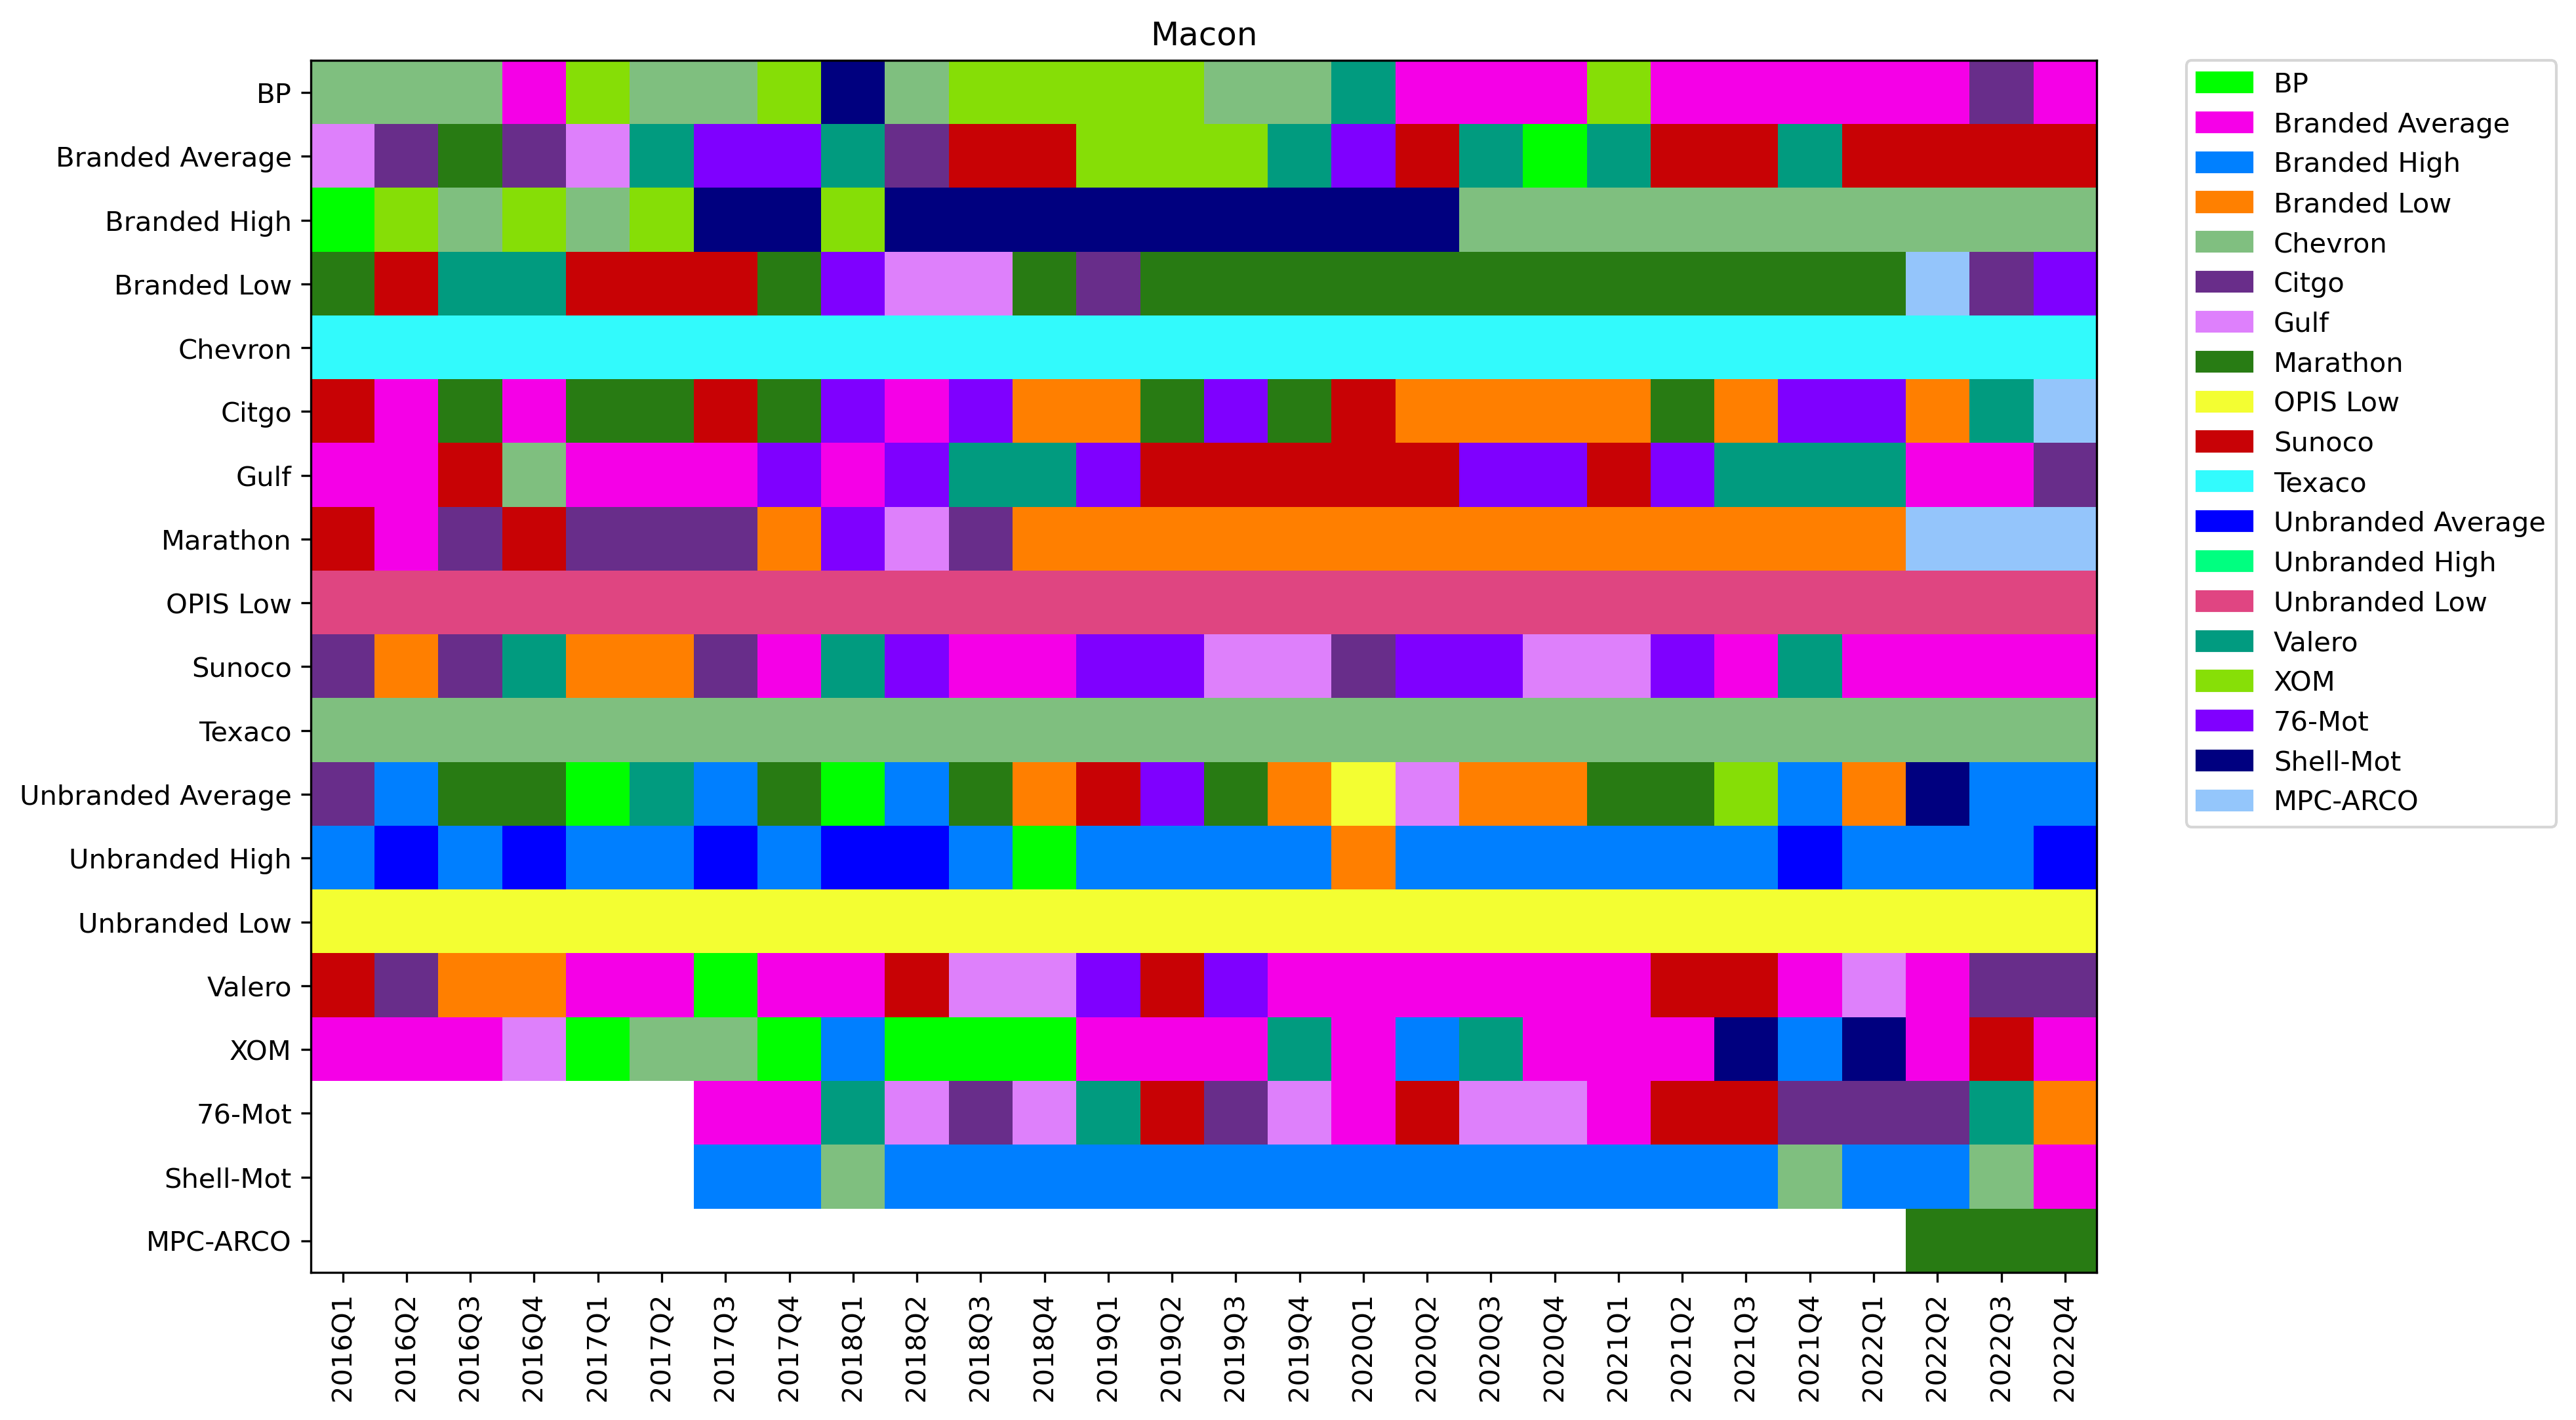

In [125]:
get_map(df_best_strats, city)

In [ ]:
display(pd.DataFrame.from_dict(best_strats, orient='index'))

In [ ]:
get_map(df_best_strats, 'shapiro')

In [ ]:
get_map(df_best_strats_diff, 'richmond')

In [ ]:
(pd.DataFrame.from_dict(best_strats_corrs, orient='index')).plot()

In [ ]:
get_map(simple_strategy_diff_matrix)

In [ ]:
get_map(simple_strategy_diff_matrix)

In [ ]:
test_strat = generate_strat('76-Mot:Atlanta:CBOB Ethanol 10%:87')
size=20
kernel=np.ones(size)/size
data=np.convolve(test_strat.discounted_gross_price,kernel,mode='same')
test_strat=pd.Series(data=data,index=test_strat.index)
test_strat.plot(linewidth=1)
p_t=ts_diff_dict['76-Mot:Atlanta:CBOB Ethanol 10%:87']['discounted_gross_price']
data=np.convolve(p_t,kernel,mode='same')
p_t=pd.Series(data=data,index=test_strat.index)

In [ ]:
test_strat = generate_strat('76-Mot:Atlanta:CBOB Ethanol 10%:87')
act_strat = ts_diff_dict['76-Mot:Atlanta:CBOB Ethanol 10%:87']['discounted_gross_price']
test_strat[datetime.date(2017, 3, 1):datetime.date(2017, 6, 30)].plot(linewidth=1, label = 'predicted')
act_strat[datetime.date(2017, 3, 1):datetime.date(2017, 6, 30)].plot(linewidth=1, label = 'actual')
plt.legend()

In [ ]:
for city in top_10:
    df_city=df_master[df_master.city==city]
    df_city = df_city[df_city.product_name == 'CBOB Ethanol 10%']
    df_city=df_city.sort_values(by=['date'])
    groupby_cols = ["supplier", "city", "product_name", "octane_level"]
    df_city = df_city.drop_duplicates(subset=["supplier", "city", "product_name", "octane_level", "date"])  
    ts_dict = {":".join([str(name) for name in names]): group.set_index("date") for names, group in df_city.groupby(groupby_cols, observed=True)}
    best_strats_diff, best_strats_diff_corrs = run_strategy(ts_dict, get_best_strats_diff)
    df_best_strats_diff = pd.DataFrame.from_dict(data=best_strats_diff, orient='columns')
    get_map(df_best_strats_diff, city)